In [1]:
import pandas as pd
import  sys
sys.path.append("//Users//davislab//Desktop//RSAlgorithms-master")
import numpy as np
from prettyprinter import cpprint
from metric import Metric
from configx.configx import ConfigX
from utility.tools import denormalize,sigmoid,normalize
# from model.mf import MF
# from model.social_rec import SocialRec

In [2]:
import sys
sys.path.append("//Users//davislab//Desktop//RSAlgorithms-master")
import os
import numpy as np
import pandas as pd
from scipy.sparse import coo_matrix
# from configx.configx import ConfigX
def split_5_folds(configx):
    K = configx.k_fold_num
    names = ['user_id', 'item_id', 'rating']
    df = pd.read_csv("//Users//davislab//Desktop//RSAlgorithms-master//data/Lthing_rating1.txt", sep=configx.sep, names=names)
    ratings = coo_matrix((df.rating, (df.user_id, df.item_id)))
    users = np.unique(ratings.row)
    ratings = ratings.tocsr()

    rows = list()
    cols = list()
    vals = list()
    nonzeros = list()

    for k in range(K):
        size_of_bucket = int(ratings.nnz / K)
        if k == K - 1:
            size_of_bucket += ratings.nnz % K
        rows.append(np.zeros(size_of_bucket))
        cols.append(np.zeros(size_of_bucket))
        vals.append(np.zeros(size_of_bucket))
        nonzeros.append(0)

    for i, user in enumerate(users):
        items = ratings[user, :].indices
        rating_vals = ratings[user, :].data
        index_list = [i for i in range(K)] * int(len(items) / float(K) + 1)
        np.random.shuffle(index_list)
        index_list = np.array(index_list)

        for k in range(K):
            k_index_list = (index_list[:len(items)] == k)
            from_ind = nonzeros[k]
            to_ind = nonzeros[k] + sum(k_index_list)

            if to_ind >= len(rows[k]):
                rows[k] = np.append(rows[k], np.zeros(size_of_bucket))
                cols[k] = np.append(cols[k], np.zeros(size_of_bucket))
                vals[k] = np.append(vals[k], np.zeros(size_of_bucket))
                k_index_list = (index_list[:len(items)] == k)

            rows[k][from_ind:to_ind] = [user] * sum(k_index_list)
            cols[k][from_ind:to_ind] = items[k_index_list]
            vals[k][from_ind:to_ind] = rating_vals[k_index_list]
            nonzeros[k] += sum(k_index_list)


    for k, (row, col, val, nonzero) in enumerate(zip(rows, cols, vals, nonzeros)):
        bucket_df = pd.DataFrame({'user': row[:nonzero], 'item': col[:nonzero], 'rating': val[:nonzero]},
                                 columns=['user', 'item', 'rating'])
        bucket_df.to_csv("/Users/davislab/Desktop/RSAlgorithms-master/data/cv/%s-%d.csv" % (configx.dataset_name, k), sep=configx.sep, header=False, index=False)
        print("%s -fold%d data generated finished!" % (configx.dataset_name, k))

    print("All Data Generated Done!")

In [3]:
configx = ConfigX()
split_5_folds(configx)

lt -fold0 data generated finished!
lt -fold1 data generated finished!
lt -fold2 data generated finished!
lt -fold3 data generated finished!
lt -fold4 data generated finished!
All Data Generated Done!


In [4]:
configx.__dict__

{'dataset_name': 'lt',
 'k_fold_num': 5,
 'rating_path': '//Users//davislab//Desktop//RSAlgorithms-master//data//Lthing_rating1.txt',
 'rating_cv_path': '//Users//davislab//Desktop//RSAlgorithms-master//data//cv//',
 'trust_path': '//Users//davislab//Desktop//RSAlgorithms-master//data//Lthing_trust.txt',
 'sep': ' ',
 'random_state': 0,
 'size': 0.8,
 'min_val': 0.5,
 'max_val': 5,
 'coldUserRating': 5,
 'factor': 10,
 'threshold': 0.0001,
 'lr': 0.01,
 'maxIter': 15,
 'lambdaP': 0.001,
 'lambdaQ': 0.001,
 'gamma': 0,
 'isEarlyStopping': False,
 'result_path': '//Users//davislab//Desktop//RSAlgorithms-master/results/',
 'model_path': 'model/',
 'result_log_path': 'log/'}

In [5]:
import  sys

import numpy as np
import matplotlib.pylab as plt

from prettyprinter import cpprint
from metrics.metric import Metric
# from utility.tools import denormalize,sigmoid
# from reader.rating import RatingGetter
# from configx.configx import ConfigX

class MF(object):
    """
    docstring for MF
    the base class for matrix factorization based model-parent class
    """

    def __init__(self):
        super(MF, self).__init__()
        self.config = ConfigX()
        cpprint(self.config.__dict__)  #print the configuration

        # self.rg = RatingGetter()  # loading raing data
        # self.init_model()
        self.iter_rmse = []
        self.iter_mae = []
        pass

    def init_model(self,k):
        self.read_data(k)
        self.P = np.random.rand(self.rg.get_train_size()[0], self.config.factor) / (self.config.factor ** 0.5)  # latent user matrix
        self.Q = np.random.rand(self.rg.get_train_size()[1], self.config.factor) / (self.config.factor ** 0.5)  # latent item matrix
        self.loss, self.lastLoss = 0.0, 0.0
        self.lastRmse, self.lastMae = 10.0,10.0
        pass

    def read_data(self,k):
        self.rg = RatingGetter(k)
        pass

    def train_model(self,k):
        self.init_model(k)
        pass

    # test all users in test set
    def predict_model(self):
        res = []
        for ind, entry in enumerate(self.rg.testSet()):
            user, item, rating = entry
            rating_length = len(self.rg.trainSet_u[user]) # remove cold start users for test
            if rating_length <= self.config.coldUserRating:
                continue

            prediction = self.predict(user, item)
            # denormalize
            prediction = denormalize(prediction, self.config.min_val, self.config.max_val)

            pred = self.checkRatingBoundary(prediction)
            # add prediction in order to measure
            res.append([user, item, rating, pred])
        rmse = Metric.RMSE(res)
        mae = Metric.MAE(res)
        self.iter_rmse.append(rmse)  # for plot
        self.iter_mae.append(mae)
        return rmse, mae

    # test cold start users among test set
    def predict_model_cold_users(self):
        res = []
        for user in self.rg.testColdUserSet_u.keys():
            for item in self.rg.testColdUserSet_u[user].keys():
                rating = self.rg.testColdUserSet_u[user][item]
                pred = self.predict(user, item)
                # pred = sigmoid(pred)
                # denormalize
                pred = denormalize(pred, self.config.min_val, self.config.max_val)
                pred = self.checkRatingBoundary(pred)
                res.append([user, item, rating, pred])
        rmse = Metric.RMSE(res)
        mae = Metric.MAE(res)
        return rmse,mae

    def predict(self, u, i):
        if self.rg.containsUser(u) and self.rg.containsItem(i):
            return self.P[self.rg.user[u]].dot(self.Q[self.rg.item[i]])
        elif self.rg.containsUser(u) and not self.rg.containsItem(i):
            return self.rg.userMeans[u]
        elif not self.rg.containsUser(u) and self.rg.containsItem(i):
            return self.rg.itemMeans[i]
        else:
            return self.rg.globalMean

    def checkRatingBoundary(self, prediction):
        prediction =round( min( max( prediction , self.config.min_val ) , self.config.max_val ) ,3)
        return prediction

    def isConverged(self, iter):
        loss=[]
        from math import isnan
        if isnan(self.loss):
            print(
                'Loss = NaN or Infinity: current settings does not fit the recommender! Change the settings and try again!')
            exit(-1)

        deltaLoss = (self.lastLoss - self.loss)
        rmse, mae = self.predict_model()

        # early stopping
        if self.config.isEarlyStopping == True:
            cond = self.lastRmse < rmse
            if cond:
                print('test rmse increase, so early stopping')
                return cond
            self.lastRmse = rmse
            self.lastMae = mae
            
        loss.append(self.loss)
        print('%s iteration %d: loss = %.4f, delta_loss = %.5f learning_Rate = %.5f rmse=%.5f mae=%.5f' % \
              (self.__class__, iter, self.loss, deltaLoss, self.config.lr, rmse, mae))

        # check if converged
        cond = abs(deltaLoss) < self.config.threshold
        converged = cond
        # if not converged:
        # self.updateLearningRate(iter)
        self.lastLoss = self.loss
        # shuffle(self.dao.trainingData)
        return converged

    def updateLearningRate(self, iter):
        if iter > 1:
            if abs(self.lastLoss) > abs(self.loss):
                self.config.lr *= 1.05
            else:
                self.config.lr *= 0.5
        if self.config.lr > 1:
            self.config.lr = 1

In [6]:
from collections import defaultdict

class TrustGetter(object):
    """
    docstring for TrustGetter
    read trust data and save the global parameters

    """

    def __init__(self):
        super(TrustGetter, self).__init__()
        self.config = ConfigX()
        self.user = {}  # used to store the order of users
        self.relations = self.get_relations()
        self.followees = defaultdict(dict)
        self.followers = {}
        self.matrix_User = {}
        self.matrix_Item = {}
        self.generate_data_set()

    def generate_data_set(self):
        triple = []
        for line in self.relations:
            userId1, userId2, weight = line
            # add relations to dict
            if not userId1 in self.followees:
                self.followees[userId1] = {}
            self.followees[userId1][userId2] = weight
            if not userId2 in self.followers:
                self.followers[userId2] = {}
            self.followers[userId2][userId1] = weight
            # order the user
            if not userId1 in self.user:
                userid1 = self.user[userId1] = len(self.user)
            if not userId2 in self.user:
                userid2 = self.user[userId2] = len(self.user)
            if not userid1 in self.matrix_User:
                self.matrix_User[userid1] = {}
            if not userid2 in self.matrix_User:
                self.matrix_Item[userid2] = {}
            self.matrix_User[userid1][userid2] = weight
            self.matrix_Item[userid2][userid1] = weight

    def get_relations(self):
        with open("//Users//davislab//Desktop//RSAlgorithms-master//data//Lthing_trust.txt", 'r') as f:
            for index, line in enumerate(f):
                u_from, u_to, t = line.strip('\r\n').split(self.config.sep)
                yield (int(u_from), int(u_to), float(t))

    def get_followees(self, u):
        if u in self.followees:
            return self.followees[u]
        else:
            return {}

    def get_followers(self, u):
        if u in self.followers:
            return self.followers[u]
        else:
            return {}

    def weight(self, u, k):
        if u in self.followees and k in self.followees[u]:
            return self.followees[u][k]
        else:
            return 0

In [18]:
from collections import defaultdict
import numpy as np

# from utility.tools import normalize
# from configx.configx import ConfigX
class RatingGetter(object):
    """
    docstring for RatingGetter
    read rating data and save the global parameters
    """

    def __init__(self, k):
        super(RatingGetter, self).__init__()
        self.config = ConfigX()
        self.k_current = k
        self.user = {}
        self.item = {}
        self.all_User = {}
        self.all_Item = {}
        self.id2user = {}
        self.id2item = {}
        self.dataSet_u = defaultdict(dict)
        self.trainSet_u = defaultdict(dict)
        self.trainSet_i = defaultdict(dict)
        self.testSet_u = defaultdict(dict)  # used to store the test set by hierarchy user:[item,rating]
        self.testSet_i = defaultdict(dict)  # used to store the test set by hierarchy item:[user,rating]
        self.testColdUserSet_u = defaultdict(dict)  # cold start users in test set
        self.trainHotUserSet = []  # hot users in train set
        self.trainSetLength = 0
        self.testSetLength = 0

        self.userMeans = {}  # used to store the mean values of users's ratings
        self.itemMeans = {}  # used to store the mean values of items's ratings
        self.globalMean = 0

        self.generate_data_set()  # generate train and test set
        self.getDataSet()
        self.get_data_statistics()
        self.get_cold_start_users()

    def generate_data_set(self):
        for index, line in enumerate(self.trainSet()):
            u, i, r = line
            # print(u,i,r)
            if not u in self.user:
                self.user[u] = len(self.user)
                self.id2user[self.user[u]] = u
            if not i in self.item:
                self.item[i] = len(self.item)
                self.id2item[self.item[i]] = i

            self.trainSet_u[u][i] = r
            self.trainSet_i[i][u] = r
            self.trainSetLength = index + 1
        self.all_User.update(self.user)
        self.all_Item.update(self.item)

        for index, line in enumerate(self.testSet()):
            u, i, r = line
            if not u in self.user:
                self.all_User[u] = len(self.all_User)
            if not i in self.item:
                self.all_Item[i] = len(self.all_Item)
            self.testSet_u[u][i] = r
            self.testSet_i[i][u] = r
            self.testSetLength = index + 1
        # print(self.trainSetLength)
        # print(self.testSetLength)
        pass

    # for cross validation
    def trainSet(self):
#       k = self.k_current   #comment when calling main the second time for testing
#       for i in range(self.config.k_fold_num):  #comment when calling main the second time for testing
#             if i != k:  #comment when calling main the second time for testing
#                   data_path = "/Users/davislab/Desktop/RSAlgorithms-master/data/cv/" + self.config.dataset_name + "-" + str(i) + ".csv"  #comment when calling main the second time for testing
        data_path = "/Users/davislab/Desktop/RSAlgorithms-master/data/Lthing_rating1.txt" #uncomment when testing on test data
        print("train_path",data_path)
                # if not os.path.exists
        if not os.path.isfile(data_path):
            print("the format of ratings data is wrong!")
            sys.exit()
        with open(data_path, 'r') as f:
            for index, line in enumerate(f):
                u, i, r = line.strip('\r\n').split(self.config.sep)
                r = normalize(float(r))  # scale the rating score to [0-1]
                yield (int(float(u)), int(float(i)), float(r))

    def testSet(self):
#         k = self.k_current   #comment when testing on test data
#         data_path = "/Users/davislab/Desktop/RSAlgorithms-master/data/cv/" + self.config.dataset_name + "-" + str(k) + ".csv" #comment when testing on test data
        data_path = "/Users/davislab/Desktop/RSAlgorithms-master/data/Lthing_rating_test.txt" #uncomment when testing on test data
        print("test_path",data_path)  
        if not os.path.isfile(data_path):
            print("the format of ratings data is wrong!")
            sys.exit()
        with open(data_path, 'r') as f:
            for index, line in enumerate(f):
                u, i, r = line.strip('\r\n').split(self.config.sep)
                yield (int(float(u)), int(float(i)), float(r))


    def getDataSet(self):
        with open("//Users//davislab//Desktop//RSAlgorithms-master//data//Lthing_rating1.txt", 'r') as f:
            for index, line in enumerate(f):
                u, i, r = line.strip('\r\n').split(self.config.sep)
                self.dataSet_u[int(u)][int(i)] = float(r)

    def get_train_size(self):
        return (len(self.user), len(self.item))

    # get cold start users in test set
    def get_cold_start_users(self):
        for user in self.testSet_u.keys():
            rating_length = len(self.trainSet_u[user])
            if rating_length <= self.config.coldUserRating:
                self.testColdUserSet_u[user] = self.testSet_u[user]
            print('cold start users count', len(self.testColdUserSet_u))

    def get_data_statistics(self):

        total_rating = 0.0
        total_length = 0
        for u in self.user:
            u_total = sum(self.trainSet_u[u].values())
            u_length = len(self.trainSet_u[u])
            total_rating += u_total
            total_length += u_length
            self.userMeans[u] = u_total / float(u_length)

        for i in self.item:
            self.itemMeans[i] = sum(self.trainSet_i[i].values()) / float(len(self.trainSet_i[i]))

        if total_length == 0:
            self.globalMean = 0
        else:
            self.globalMean = total_rating / total_length

    def containsUser(self, u):
        'whether user is in training set'
        if u in self.user:
            return True
        else:
            return False

    def containsItem(self, i):
        'whether item is in training set'
        if i in self.item:
            return True
        else:
            return False

    def containsUserItem(self, user, item):
        if user in self.trainSet_u:
            if item in self.trainSet_u[user]:
                # print(user)
                # print(item)
                # print(self.trainSet_u[user][item])
                return True
        return False

    def get_row(self, u):
        return self.trainSet_u[u]

    def get_col(self, c):
        return self.trainSet_i[c]

    def user_rated_items(self, u):
        return self.trainSet_u[u].keys()

In [11]:
class SocialRec(MF):
    """
    docstring for SocialRec
    Ma H, Yang H, Lyu M R, et al. Sorec: social recommendation using probabilistic matrix factorization[C]//Proceedings of the 17th ACM conference on Information and knowledge management. ACM, 2008: 931-940.
    """

    def __init__(self):
        super(SocialRec, self).__init__()
        # self.config.lr=0.0001
        self.config.alpha = 0.1
        self.config.lambdaZ = 0.01
        self.tg = TrustGetter()
        # self.init_model()

    def init_model(self, k):
        super(SocialRec, self).init_model(k)
        self.Z = np.random.rand(self.rg.get_train_size()[0], self.config.factor) / (
                self.config.factor ** 0.5)  # latent user social matrix

    def train_model(self, k):
        super(SocialRec, self).train_model(k)
        iteration = 0
        while iteration < self.config.maxIter:
            # tempP=np.zeros((self.rg.get_train_size()[0], self.config.factor))
            self.loss = 0
            for index, line in enumerate(self.rg.trainSet()):
                user, item, rating = line
                u = self.rg.user[user]
                i = self.rg.item[item]
                error = rating - self.predict(user, item)
                self.loss += error ** 2
                p, q = self.P[u], self.Q[i]

                followees = self.tg.get_followees(user)
                zs = np.zeros(self.config.factor)
                for followee in followees:
                    if self.rg.containsUser(user) and self.rg.containsUser(followee):
                        vminus = len(self.tg.get_followers(followee))  # ~ d - (k)
                        uplus = len(self.tg.get_followees(user))  # ~ d + (i)
                        import math
                        try:
                            weight = math.sqrt(vminus / (uplus + vminus + 0.0))
                        except ZeroDivisionError:
                            weight = 1
                        zid = self.rg.user[followee]
                        z = self.Z[zid]
                        err = weight - z.dot(p)
                        self.loss += err ** 2
                        zs += -1.0 * err * p
                        self.Z[zid] += self.config.lr * (self.config.alpha * err * p - self.config.lambdaZ * z)

                self.P[u] += self.config.lr * (error * q - self.config.alpha * zs - self.config.lambdaP * p)
                self.Q[i] += self.config.lr * (error * p - self.config.lambdaQ * q)

            self.loss += self.config.lambdaP * (self.P * self.P).sum() + self.config.lambdaQ * (self.Q * self.Q).sum() \
                         + self.config.lambdaZ * (self.Z * self.Z).sum()

            iteration += 1
            if self.isConverged(iteration):
                break

In [9]:
if __name__ == '__main__':
    rmses_cv = []
    maes_cv = []
    tcsr = SocialRec()
    # print(bmf.rg.trainSet_u[1])
    for i in range(tcsr.config.k_fold_num):
        print('the %dth cross validation training' % i)
        tcsr.train_model(i)
        rmse, mae = tcsr.predict_model()
        rmses_cv.append(rmse)
        maes_cv.append(mae)
    rmse_avg_cv = sum(rmses_cv) / 5
    mae_avg_cv = sum(maes_cv) / 5
    print("the rmses for cv are %s" % rmses_cv)
    print("the maes for cv are %s" % maes_cv)
    print("the average of rmses for cv is %s " % rmse_avg_cv)
    print("the average of maes for cv is %s " % mae_avg_cv)

{
    'dataset_name': 'lt',
    'k_fold_num': 5,
    'rating_path':
        '//Users//davislab//Desktop//RSAlgorithms-master//data//'
        'Lthing_rating1.txt',
    'rating_cv_path': '//Users//davislab//Desktop//RSAlgorithms-master//data//cv//',
    'trust_path':
        '//Users//davislab//Desktop//RSAlgorithms-master//data//Lthing_trust.'
        'txt',
    'sep': ' ',
    'random_state': 0,
    'size': 0.8,
    'min_val': 0.5,
    'max_val': 5,
    'coldUserRating': 5,
    'factor': 10,
    'threshold': 0.0001,
    'lr': 0.01,
    'maxIter': 15,
    'lambdaP': 0.001,
    'lambdaQ': 0.001,
    'gamma': 0,
    'isEarlyStopping': False,
    'result_path': '//Users//davislab//Desktop//RSAlgorithms-master/results/',
    'model_path': 'model/',
    'result_log_path': 'log/'
}
the 0th cross validation training
train_path /Users/davislab/Desktop/RSAlgorithms-master/data/cv/lt-1.csv
train_path /Users/davislab/Desktop/RSAlgorithms-master/data/cv/lt-2.csv
train_path /Users/davislab/Desktop/

train_path /Users/davislab/Desktop/RSAlgorithms-master/data/cv/lt-3.csv
train_path /Users/davislab/Desktop/RSAlgorithms-master/data/cv/lt-4.csv
test_path /Users/davislab/Desktop/RSAlgorithms-master/data/cv/lt-0.csv
<class '__main__.SocialRec'> iteration 15: loss = 134203.0321, delta_loss = 3735.97085 learning_Rate = 0.01000 rmse=1.18464 mae=0.90402
test_path /Users/davislab/Desktop/RSAlgorithms-master/data/cv/lt-0.csv
the 1th cross validation training
train_path /Users/davislab/Desktop/RSAlgorithms-master/data/cv/lt-0.csv
train_path /Users/davislab/Desktop/RSAlgorithms-master/data/cv/lt-2.csv
train_path /Users/davislab/Desktop/RSAlgorithms-master/data/cv/lt-3.csv
train_path /Users/davislab/Desktop/RSAlgorithms-master/data/cv/lt-4.csv
test_path /Users/davislab/Desktop/RSAlgorithms-master/data/cv/lt-1.csv
train_path /Users/davislab/Desktop/RSAlgorithms-master/data/cv/lt-0.csv
train_path /Users/davislab/Desktop/RSAlgorithms-master/data/cv/lt-2.csv
train_path /Users/davislab/Desktop/RSAlgo

the 2th cross validation training
train_path /Users/davislab/Desktop/RSAlgorithms-master/data/cv/lt-0.csv
train_path /Users/davislab/Desktop/RSAlgorithms-master/data/cv/lt-1.csv
train_path /Users/davislab/Desktop/RSAlgorithms-master/data/cv/lt-3.csv
train_path /Users/davislab/Desktop/RSAlgorithms-master/data/cv/lt-4.csv
test_path /Users/davislab/Desktop/RSAlgorithms-master/data/cv/lt-2.csv
train_path /Users/davislab/Desktop/RSAlgorithms-master/data/cv/lt-0.csv
train_path /Users/davislab/Desktop/RSAlgorithms-master/data/cv/lt-1.csv
train_path /Users/davislab/Desktop/RSAlgorithms-master/data/cv/lt-3.csv
train_path /Users/davislab/Desktop/RSAlgorithms-master/data/cv/lt-4.csv
test_path /Users/davislab/Desktop/RSAlgorithms-master/data/cv/lt-2.csv
<class '__main__.SocialRec'> iteration 1: loss = 452224.7507, delta_loss = -452224.75071 learning_Rate = 0.01000 rmse=1.63687 mae=1.35295
train_path /Users/davislab/Desktop/RSAlgorithms-master/data/cv/lt-0.csv
train_path /Users/davislab/Desktop/RSA

test_path /Users/davislab/Desktop/RSAlgorithms-master/data/cv/lt-3.csv
train_path /Users/davislab/Desktop/RSAlgorithms-master/data/cv/lt-0.csv
train_path /Users/davislab/Desktop/RSAlgorithms-master/data/cv/lt-1.csv
train_path /Users/davislab/Desktop/RSAlgorithms-master/data/cv/lt-2.csv
train_path /Users/davislab/Desktop/RSAlgorithms-master/data/cv/lt-4.csv
test_path /Users/davislab/Desktop/RSAlgorithms-master/data/cv/lt-3.csv
<class '__main__.SocialRec'> iteration 1: loss = 454598.1786, delta_loss = -454598.17862 learning_Rate = 0.01000 rmse=1.64055 mae=1.35597
train_path /Users/davislab/Desktop/RSAlgorithms-master/data/cv/lt-0.csv
train_path /Users/davislab/Desktop/RSAlgorithms-master/data/cv/lt-1.csv
train_path /Users/davislab/Desktop/RSAlgorithms-master/data/cv/lt-2.csv
train_path /Users/davislab/Desktop/RSAlgorithms-master/data/cv/lt-4.csv
test_path /Users/davislab/Desktop/RSAlgorithms-master/data/cv/lt-3.csv
<class '__main__.SocialRec'> iteration 2: loss = 309148.4796, delta_loss 

test_path /Users/davislab/Desktop/RSAlgorithms-master/data/cv/lt-4.csv
<class '__main__.SocialRec'> iteration 1: loss = 453752.2507, delta_loss = -453752.25065 learning_Rate = 0.01000 rmse=1.63941 mae=1.35695
train_path /Users/davislab/Desktop/RSAlgorithms-master/data/cv/lt-0.csv
train_path /Users/davislab/Desktop/RSAlgorithms-master/data/cv/lt-1.csv
train_path /Users/davislab/Desktop/RSAlgorithms-master/data/cv/lt-2.csv
train_path /Users/davislab/Desktop/RSAlgorithms-master/data/cv/lt-3.csv
test_path /Users/davislab/Desktop/RSAlgorithms-master/data/cv/lt-4.csv
<class '__main__.SocialRec'> iteration 2: loss = 309330.4396, delta_loss = 144421.81105 learning_Rate = 0.01000 rmse=1.49231 mae=1.21108
train_path /Users/davislab/Desktop/RSAlgorithms-master/data/cv/lt-0.csv
train_path /Users/davislab/Desktop/RSAlgorithms-master/data/cv/lt-1.csv
train_path /Users/davislab/Desktop/RSAlgorithms-master/data/cv/lt-2.csv
train_path /Users/davislab/Desktop/RSAlgorithms-master/data/cv/lt-3.csv
test_pa

In [19]:
#calling again for making prediction on unseen test set
if __name__ == '__main__':
    rmses_test = []
    maes_test = []
    tcsr = SocialRec()
    tcsr.train_model(0)  #train on whole training set and predict on using unseen test data
    rmse, mae = tcsr.predict_model()
    rmses_test.append(rmse)
    maes_test.append(mae)
    print("the rmses for test are %s" % rmses_test)
    print("the maes for test are %s" % maes_test)

{
    'dataset_name': 'lt',
    'k_fold_num': 5,
    'rating_path':
        '//Users//davislab//Desktop//RSAlgorithms-master//data//'
        'Lthing_rating1.txt',
    'rating_cv_path': '//Users//davislab//Desktop//RSAlgorithms-master//data//cv//',
    'trust_path':
        '//Users//davislab//Desktop//RSAlgorithms-master//data//Lthing_trust.'
        'txt',
    'sep': ' ',
    'random_state': 0,
    'size': 0.8,
    'min_val': 0.5,
    'max_val': 5,
    'coldUserRating': 5,
    'factor': 10,
    'threshold': 0.0001,
    'lr': 0.01,
    'maxIter': 15,
    'lambdaP': 0.001,
    'lambdaQ': 0.001,
    'gamma': 0,
    'isEarlyStopping': False,
    'result_path': '//Users//davislab//Desktop//RSAlgorithms-master/results/',
    'model_path': 'model/',
    'result_log_path': 'log/'
}
train_path /Users/davislab/Desktop/RSAlgorithms-master/data/Lthing_rating1.txt
test_path /Users/davislab/Desktop/RSAlgorithms-master/data/Lthing_rating_test.txt
cold start users count 0
cold start users count 1
co

cold start users count 181
cold start users count 181
cold start users count 181
cold start users count 181
cold start users count 181
cold start users count 181
cold start users count 181
cold start users count 181
cold start users count 181
cold start users count 181
cold start users count 181
cold start users count 181
cold start users count 181
cold start users count 181
cold start users count 182
cold start users count 182
cold start users count 183
cold start users count 183
cold start users count 183
cold start users count 183
cold start users count 183
cold start users count 183
cold start users count 183
cold start users count 183
cold start users count 184
cold start users count 184
cold start users count 184
cold start users count 184
cold start users count 184
cold start users count 184
cold start users count 185
cold start users count 185
cold start users count 185
cold start users count 185
cold start users count 185
cold start users count 185
cold start users count 185
c

cold start users count 354
cold start users count 354
cold start users count 354
cold start users count 354
cold start users count 354
cold start users count 354
cold start users count 354
cold start users count 354
cold start users count 354
cold start users count 354
cold start users count 354
cold start users count 354
cold start users count 354
cold start users count 354
cold start users count 354
cold start users count 355
cold start users count 355
cold start users count 355
cold start users count 355
cold start users count 355
cold start users count 355
cold start users count 355
cold start users count 355
cold start users count 355
cold start users count 355
cold start users count 355
cold start users count 355
cold start users count 355
cold start users count 356
cold start users count 356
cold start users count 356
cold start users count 357
cold start users count 357
cold start users count 357
cold start users count 357
cold start users count 358
cold start users count 358
c

cold start users count 590
cold start users count 591
cold start users count 591
cold start users count 591
cold start users count 591
cold start users count 591
cold start users count 591
cold start users count 591
cold start users count 591
cold start users count 591
cold start users count 591
cold start users count 591
cold start users count 591
cold start users count 591
cold start users count 591
cold start users count 591
cold start users count 591
cold start users count 591
cold start users count 591
cold start users count 592
cold start users count 592
cold start users count 592
cold start users count 593
cold start users count 593
cold start users count 594
cold start users count 595
cold start users count 595
cold start users count 595
cold start users count 596
cold start users count 596
cold start users count 596
cold start users count 596
cold start users count 596
cold start users count 596
cold start users count 596
cold start users count 597
cold start users count 597
c

cold start users count 872
cold start users count 872
cold start users count 872
cold start users count 872
cold start users count 872
cold start users count 872
cold start users count 873
cold start users count 873
cold start users count 873
cold start users count 873
cold start users count 873
cold start users count 873
cold start users count 873
cold start users count 874
cold start users count 874
cold start users count 874
cold start users count 874
cold start users count 874
cold start users count 874
cold start users count 874
cold start users count 874
cold start users count 874
cold start users count 874
cold start users count 874
cold start users count 875
cold start users count 875
cold start users count 875
cold start users count 875
cold start users count 875
cold start users count 875
cold start users count 875
cold start users count 875
cold start users count 875
cold start users count 875
cold start users count 875
cold start users count 875
cold start users count 875
c

cold start users count 1212
cold start users count 1212
cold start users count 1212
cold start users count 1212
cold start users count 1212
cold start users count 1213
cold start users count 1213
cold start users count 1213
cold start users count 1214
cold start users count 1214
cold start users count 1214
cold start users count 1214
cold start users count 1214
cold start users count 1214
cold start users count 1215
cold start users count 1215
cold start users count 1215
cold start users count 1215
cold start users count 1215
cold start users count 1215
cold start users count 1215
cold start users count 1216
cold start users count 1217
cold start users count 1217
cold start users count 1217
cold start users count 1217
cold start users count 1217
cold start users count 1217
cold start users count 1218
cold start users count 1218
cold start users count 1218
cold start users count 1218
cold start users count 1218
cold start users count 1218
cold start users count 1218
cold start users cou

cold start users count 1571
cold start users count 1571
cold start users count 1571
cold start users count 1571
cold start users count 1571
cold start users count 1571
cold start users count 1571
cold start users count 1571
cold start users count 1571
cold start users count 1571
cold start users count 1571
cold start users count 1571
cold start users count 1571
cold start users count 1571
cold start users count 1571
cold start users count 1571
cold start users count 1571
cold start users count 1571
cold start users count 1571
cold start users count 1571
cold start users count 1571
cold start users count 1571
cold start users count 1572
cold start users count 1572
cold start users count 1572
cold start users count 1573
cold start users count 1573
cold start users count 1573
cold start users count 1574
cold start users count 1574
cold start users count 1575
cold start users count 1575
cold start users count 1575
cold start users count 1575
cold start users count 1575
cold start users cou

cold start users count 2017
cold start users count 2017
cold start users count 2017
cold start users count 2017
cold start users count 2017
cold start users count 2018
cold start users count 2018
cold start users count 2018
cold start users count 2018
cold start users count 2018
cold start users count 2018
cold start users count 2019
cold start users count 2020
cold start users count 2020
cold start users count 2021
cold start users count 2022
cold start users count 2022
cold start users count 2022
cold start users count 2022
cold start users count 2022
cold start users count 2022
cold start users count 2022
cold start users count 2023
cold start users count 2023
cold start users count 2023
cold start users count 2023
cold start users count 2023
cold start users count 2023
cold start users count 2023
cold start users count 2024
cold start users count 2024
cold start users count 2024
cold start users count 2024
cold start users count 2025
cold start users count 2025
cold start users cou

cold start users count 2502
cold start users count 2502
cold start users count 2503
cold start users count 2504
cold start users count 2504
cold start users count 2504
cold start users count 2504
cold start users count 2504
cold start users count 2504
cold start users count 2504
cold start users count 2504
cold start users count 2504
cold start users count 2504
cold start users count 2504
cold start users count 2504
cold start users count 2505
cold start users count 2506
cold start users count 2506
cold start users count 2506
cold start users count 2506
cold start users count 2506
cold start users count 2507
cold start users count 2507
cold start users count 2507
cold start users count 2507
cold start users count 2508
cold start users count 2508
cold start users count 2509
cold start users count 2510
cold start users count 2510
cold start users count 2510
cold start users count 2510
cold start users count 2510
cold start users count 2511
cold start users count 2512
cold start users cou

cold start users count 2994
cold start users count 2994
cold start users count 2994
cold start users count 2995
cold start users count 2995
cold start users count 2995
cold start users count 2996
cold start users count 2996
cold start users count 2996
cold start users count 2997
cold start users count 2997
cold start users count 2997
cold start users count 2997
cold start users count 2997
cold start users count 2998
cold start users count 2999
cold start users count 2999
cold start users count 3000
cold start users count 3000
cold start users count 3000
cold start users count 3000
cold start users count 3000
cold start users count 3000
cold start users count 3000
cold start users count 3000
cold start users count 3000
cold start users count 3000
cold start users count 3001
cold start users count 3002
cold start users count 3002
cold start users count 3002
cold start users count 3003
cold start users count 3003
cold start users count 3004
cold start users count 3004
cold start users cou

cold start users count 3573
cold start users count 3573
cold start users count 3573
cold start users count 3573
cold start users count 3574
cold start users count 3574
cold start users count 3575
cold start users count 3575
cold start users count 3576
cold start users count 3576
cold start users count 3576
cold start users count 3577
cold start users count 3578
cold start users count 3578
cold start users count 3578
cold start users count 3578
cold start users count 3578
cold start users count 3579
cold start users count 3580
cold start users count 3580
cold start users count 3581
cold start users count 3581
cold start users count 3582
cold start users count 3583
cold start users count 3583
cold start users count 3584
cold start users count 3585
cold start users count 3585
cold start users count 3585
cold start users count 3585
cold start users count 3586
cold start users count 3586
cold start users count 3586
cold start users count 3586
cold start users count 3586
cold start users cou

cold start users count 4181
cold start users count 4182
cold start users count 4183
cold start users count 4184
cold start users count 4184
cold start users count 4185
cold start users count 4185
cold start users count 4185
cold start users count 4185
cold start users count 4185
cold start users count 4186
cold start users count 4187
cold start users count 4187
cold start users count 4187
cold start users count 4187
cold start users count 4187
cold start users count 4188
cold start users count 4189
cold start users count 4189
cold start users count 4190
cold start users count 4190
cold start users count 4191
cold start users count 4192
cold start users count 4192
cold start users count 4192
cold start users count 4192
cold start users count 4193
cold start users count 4193
cold start users count 4194
cold start users count 4194
cold start users count 4195
cold start users count 4195
cold start users count 4195
cold start users count 4196
cold start users count 4196
cold start users cou

cold start users count 4845
cold start users count 4845
cold start users count 4845
cold start users count 4846
cold start users count 4846
cold start users count 4847
cold start users count 4847
cold start users count 4848
cold start users count 4849
cold start users count 4849
cold start users count 4850
cold start users count 4850
cold start users count 4851
cold start users count 4851
cold start users count 4851
cold start users count 4852
cold start users count 4852
cold start users count 4852
cold start users count 4853
cold start users count 4853
cold start users count 4853
cold start users count 4854
cold start users count 4854
cold start users count 4854
cold start users count 4855
cold start users count 4855
cold start users count 4856
cold start users count 4856
cold start users count 4856
cold start users count 4857
cold start users count 4857
cold start users count 4857
cold start users count 4857
cold start users count 4858
cold start users count 4859
cold start users cou

cold start users count 5589
cold start users count 5589
cold start users count 5589
cold start users count 5590
cold start users count 5591
cold start users count 5591
cold start users count 5591
cold start users count 5591
cold start users count 5591
cold start users count 5591
cold start users count 5591
cold start users count 5592
cold start users count 5592
cold start users count 5593
cold start users count 5593
cold start users count 5593
cold start users count 5593
cold start users count 5594
cold start users count 5594
cold start users count 5594
cold start users count 5594
cold start users count 5595
cold start users count 5595
cold start users count 5595
cold start users count 5596
cold start users count 5597
cold start users count 5597
cold start users count 5597
cold start users count 5597
cold start users count 5597
cold start users count 5597
cold start users count 5597
cold start users count 5598
cold start users count 5598
cold start users count 5598
cold start users cou

cold start users count 6378
cold start users count 6378
cold start users count 6379
cold start users count 6379
cold start users count 6380
cold start users count 6380
cold start users count 6380
cold start users count 6380
cold start users count 6381
cold start users count 6382
cold start users count 6382
cold start users count 6383
cold start users count 6383
cold start users count 6384
cold start users count 6384
cold start users count 6385
cold start users count 6385
cold start users count 6385
cold start users count 6386
cold start users count 6386
cold start users count 6387
cold start users count 6388
cold start users count 6389
cold start users count 6390
cold start users count 6391
cold start users count 6392
cold start users count 6392
cold start users count 6393
cold start users count 6394
cold start users count 6394
cold start users count 6394
cold start users count 6394
cold start users count 6395
cold start users count 6396
cold start users count 6396
cold start users cou

cold start users count 7193
cold start users count 7194
cold start users count 7194
cold start users count 7195
cold start users count 7196
cold start users count 7197
cold start users count 7197
cold start users count 7197
cold start users count 7198
cold start users count 7198
cold start users count 7199
cold start users count 7200
cold start users count 7200
cold start users count 7200
cold start users count 7201
cold start users count 7201
cold start users count 7202
cold start users count 7203
cold start users count 7203
cold start users count 7204
cold start users count 7205
cold start users count 7205
cold start users count 7205
cold start users count 7205
cold start users count 7205
cold start users count 7206
cold start users count 7206
cold start users count 7206
cold start users count 7206
cold start users count 7206
cold start users count 7207
cold start users count 7207
cold start users count 7207
cold start users count 7207
cold start users count 7207
cold start users cou

cold start users count 8124
cold start users count 8125
cold start users count 8126
cold start users count 8127
cold start users count 8128
cold start users count 8128
cold start users count 8128
cold start users count 8128
cold start users count 8128
cold start users count 8129
cold start users count 8129
cold start users count 8129
cold start users count 8130
cold start users count 8130
cold start users count 8130
cold start users count 8130
cold start users count 8130
cold start users count 8130
cold start users count 8131
cold start users count 8132
cold start users count 8132
cold start users count 8132
cold start users count 8132
cold start users count 8133
cold start users count 8133
cold start users count 8133
cold start users count 8134
cold start users count 8134
cold start users count 8134
cold start users count 8134
cold start users count 8135
cold start users count 8136
cold start users count 8137
cold start users count 8137
cold start users count 8137
cold start users cou

cold start users count 9060
cold start users count 9060
cold start users count 9060
cold start users count 9060
cold start users count 9061
cold start users count 9062
cold start users count 9063
cold start users count 9063
cold start users count 9064
cold start users count 9065
cold start users count 9066
cold start users count 9066
cold start users count 9067
cold start users count 9068
cold start users count 9068
cold start users count 9068
cold start users count 9068
cold start users count 9069
cold start users count 9069
cold start users count 9070
cold start users count 9071
cold start users count 9071
cold start users count 9071
cold start users count 9072
cold start users count 9073
cold start users count 9074
cold start users count 9075
cold start users count 9076
cold start users count 9077
cold start users count 9078
cold start users count 9078
cold start users count 9078
cold start users count 9079
cold start users count 9079
cold start users count 9079
cold start users cou

cold start users count 9978
cold start users count 9978
cold start users count 9979
cold start users count 9980
cold start users count 9981
cold start users count 9981
cold start users count 9982
cold start users count 9983
cold start users count 9984
cold start users count 9984
cold start users count 9985
cold start users count 9985
cold start users count 9985
cold start users count 9985
cold start users count 9985
cold start users count 9985
cold start users count 9986
cold start users count 9987
cold start users count 9988
cold start users count 9988
cold start users count 9989
cold start users count 9989
cold start users count 9990
cold start users count 9990
cold start users count 9990
cold start users count 9991
cold start users count 9991
cold start users count 9991
cold start users count 9992
cold start users count 9993
cold start users count 9994
cold start users count 9995
cold start users count 9996
cold start users count 9997
cold start users count 9998
cold start users cou

cold start users count 11044
cold start users count 11045
cold start users count 11046
cold start users count 11047
cold start users count 11047
cold start users count 11048
cold start users count 11048
cold start users count 11048
cold start users count 11048
cold start users count 11049
cold start users count 11050
cold start users count 11050
cold start users count 11050
cold start users count 11051
cold start users count 11052
cold start users count 11053
cold start users count 11054
cold start users count 11054
cold start users count 11055
cold start users count 11056
cold start users count 11057
cold start users count 11058
cold start users count 11059
cold start users count 11059
cold start users count 11059
cold start users count 11060
cold start users count 11060
cold start users count 11060
cold start users count 11060
cold start users count 11060
cold start users count 11061
cold start users count 11061
cold start users count 11062
cold start users count 11063
cold start use

cold start users count 12142
cold start users count 12143
cold start users count 12144
cold start users count 12145
cold start users count 12145
cold start users count 12146
cold start users count 12146
cold start users count 12146
cold start users count 12147
cold start users count 12148
cold start users count 12149
cold start users count 12150
cold start users count 12150
cold start users count 12151
cold start users count 12152
cold start users count 12153
cold start users count 12154
cold start users count 12155
cold start users count 12156
cold start users count 12157
cold start users count 12158
cold start users count 12158
cold start users count 12159
cold start users count 12160
cold start users count 12161
cold start users count 12162
cold start users count 12163
cold start users count 12164
cold start users count 12165
cold start users count 12166
cold start users count 12167
cold start users count 12167
cold start users count 12167
cold start users count 12167
cold start use

cold start users count 13366
cold start users count 13366
cold start users count 13367
cold start users count 13368
cold start users count 13369
cold start users count 13370
cold start users count 13371
cold start users count 13372
cold start users count 13373
cold start users count 13374
cold start users count 13375
cold start users count 13376
cold start users count 13377
cold start users count 13377
cold start users count 13377
cold start users count 13378
cold start users count 13378
cold start users count 13379
cold start users count 13379
cold start users count 13379
cold start users count 13379
cold start users count 13380
cold start users count 13380
cold start users count 13381
cold start users count 13381
cold start users count 13382
cold start users count 13383
cold start users count 13384
cold start users count 13385
cold start users count 13385
cold start users count 13386
cold start users count 13387
cold start users count 13388
cold start users count 13389
cold start use

cold start users count 14594
cold start users count 14595
cold start users count 14595
cold start users count 14596
cold start users count 14597
cold start users count 14597
cold start users count 14597
cold start users count 14598
cold start users count 14599
cold start users count 14600
cold start users count 14601
cold start users count 14602
cold start users count 14603
cold start users count 14604
cold start users count 14605
cold start users count 14606
cold start users count 14607
cold start users count 14607
cold start users count 14608
cold start users count 14609
cold start users count 14610
cold start users count 14610
cold start users count 14610
cold start users count 14611
cold start users count 14611
cold start users count 14612
cold start users count 14613
cold start users count 14613
cold start users count 14614
cold start users count 14615
cold start users count 14616
cold start users count 14617
cold start users count 14617
cold start users count 14618
cold start use

cold start users count 15911
cold start users count 15911
cold start users count 15911
cold start users count 15912
cold start users count 15913
cold start users count 15914
cold start users count 15915
cold start users count 15916
cold start users count 15917
cold start users count 15918
cold start users count 15919
cold start users count 15920
cold start users count 15920
cold start users count 15921
cold start users count 15922
cold start users count 15923
cold start users count 15924
cold start users count 15925
cold start users count 15925
cold start users count 15925
cold start users count 15925
cold start users count 15926
cold start users count 15926
cold start users count 15926
cold start users count 15927
cold start users count 15928
cold start users count 15929
cold start users count 15929
cold start users count 15929
cold start users count 15929
cold start users count 15930
cold start users count 15931
cold start users count 15932
cold start users count 15933
cold start use

cold start users count 17230
cold start users count 17231
cold start users count 17232
cold start users count 17232
cold start users count 17233
cold start users count 17234
cold start users count 17234
cold start users count 17234
cold start users count 17235
cold start users count 17236
cold start users count 17237
cold start users count 17237
cold start users count 17238
cold start users count 17239
cold start users count 17240
cold start users count 17241
cold start users count 17241
cold start users count 17242
cold start users count 17243
cold start users count 17243
cold start users count 17244
cold start users count 17245
cold start users count 17245
cold start users count 17246
cold start users count 17247
cold start users count 17248
cold start users count 17249
cold start users count 17250
cold start users count 17251
cold start users count 17252
cold start users count 17253
cold start users count 17254
cold start users count 17255
cold start users count 17256
cold start use

cold start users count 18564
cold start users count 18565
cold start users count 18565
cold start users count 18566
cold start users count 18566
cold start users count 18566
cold start users count 18567
cold start users count 18568
cold start users count 18569
cold start users count 18570
cold start users count 18571
cold start users count 18571
cold start users count 18571
cold start users count 18572
cold start users count 18573
cold start users count 18574
cold start users count 18574
cold start users count 18574
cold start users count 18575
cold start users count 18576
cold start users count 18577
cold start users count 18578
cold start users count 18579
cold start users count 18580
cold start users count 18581
cold start users count 18582
cold start users count 18582
cold start users count 18582
cold start users count 18583
cold start users count 18583
cold start users count 18584
cold start users count 18585
cold start users count 18586
cold start users count 18586
cold start use

cold start users count 19942
cold start users count 19943
cold start users count 19944
cold start users count 19945
cold start users count 19945
cold start users count 19945
cold start users count 19946
cold start users count 19946
cold start users count 19947
cold start users count 19948
cold start users count 19949
cold start users count 19950
cold start users count 19951
cold start users count 19951
cold start users count 19952
cold start users count 19952
cold start users count 19953
cold start users count 19953
cold start users count 19953
cold start users count 19953
cold start users count 19954
cold start users count 19955
cold start users count 19956
cold start users count 19957
cold start users count 19958
cold start users count 19959
cold start users count 19960
cold start users count 19961
cold start users count 19962
cold start users count 19963
cold start users count 19964
cold start users count 19965
cold start users count 19966
cold start users count 19967
cold start use

test_path /Users/davislab/Desktop/RSAlgorithms-master/data/Lthing_rating_test.txt
<class '__main__.SocialRec'> iteration 1: loss = 556350.5841, delta_loss = -556350.58411 learning_Rate = 0.01000 rmse=1.60833 mae=1.32561
train_path /Users/davislab/Desktop/RSAlgorithms-master/data/Lthing_rating1.txt
test_path /Users/davislab/Desktop/RSAlgorithms-master/data/Lthing_rating_test.txt
<class '__main__.SocialRec'> iteration 2: loss = 367862.8887, delta_loss = 188487.69543 learning_Rate = 0.01000 rmse=1.46404 mae=1.18225
train_path /Users/davislab/Desktop/RSAlgorithms-master/data/Lthing_rating1.txt
test_path /Users/davislab/Desktop/RSAlgorithms-master/data/Lthing_rating_test.txt
<class '__main__.SocialRec'> iteration 3: loss = 305767.8731, delta_loss = 62095.01560 learning_Rate = 0.01000 rmse=1.38515 mae=1.10503
train_path /Users/davislab/Desktop/RSAlgorithms-master/data/Lthing_rating1.txt
test_path /Users/davislab/Desktop/RSAlgorithms-master/data/Lthing_rating_test.txt
<class '__main__.SocialR

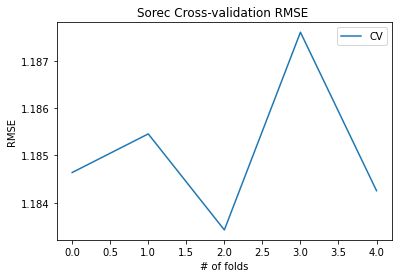

In [20]:
plt.plot(rmses_cv, label='CV')
plt.xlabel('# of folds')
plt.ylabel('RMSE')
plt.title("Sorec Cross-validation RMSE ")
plt.legend()
plt.show()